In [1]:
import pandas as pd
import os, pdb, copy
import numpy as np
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
def clean_time_series_data(df, cgm_cols=["Dexcom GL", "Libre GL"], activity_cols=["HR", "METs"]):
    """Clean and validate time-series data"""
    # Copy to avoid modifying original
    df = df.copy()
    
    # 1. Handle missing values
    for col in cgm_cols + activity_cols:
        if col in df.columns:
            # Linear interpolation with 5-minute window
            df[col] = df[col].interpolate(method='linear', limit=5)
            # Forward/backward fill remaining
            df[col] = df[col].ffill().bfill()
    
    return df

def load_daily_traces(
    dataset_df: pd.DataFrame, 
    subject_id: int,
    cgm_cols=["Dexcom GL", "Libre GL"],
    activity_cols=["HR", "METs"],
    img_size=(112, 112),
    start_hour=4  # Start at 6 AM
):
    """
    Enhanced version with full-day (1440 minute) time features.
    """
    # Cleaning functions remain the same
    def clean_series(series):
        series = series.interpolate(method='linear', limit=5).ffill().bfill()
        try:
            from scipy.signal import savgol_filter
            series = savgol_filter(series, window_length=15, polyorder=2)
        except ImportError:
            series = series.rolling(window=15, min_periods=1, center=True).mean()
        return series

    # Apply cleaning
    cleaned_df = dataset_df.copy()
    for col in cgm_cols + activity_cols:
        if col in cleaned_df.columns:
            cleaned_df[col] = clean_series(cleaned_df[col])
    
    # Resample to 1-minute frequency
    resampled_df = cleaned_df.resample('1min').ffill(limit=5)
    
    # Fill NaNs with median
    for col in cgm_cols + activity_cols:
        if col in resampled_df.columns:
            resampled_df[col] = resampled_df[col].fillna(resampled_df[col].median())
    
    # Statistics for normalization
    cgm_stats = {
        'mean': resampled_df[cgm_cols].mean().values if all(col in resampled_df.columns for col in cgm_cols) else np.zeros(len(cgm_cols)),
        'std': resampled_df[cgm_cols].std().values if all(col in resampled_df.columns for col in cgm_cols) else np.ones(len(cgm_cols))
    }
    activity_stats = {
        'mean': resampled_df[activity_cols].mean().values if all(col in resampled_df.columns for col in activity_cols) else np.zeros(len(activity_cols)),
        'std': resampled_df[activity_cols].std().values if all(col in resampled_df.columns for col in activity_cols) else np.ones(len(activity_cols))
    }

    # Initialize arrays and dictionaries
    days = pd.Series(resampled_df.index.date).unique()
    days_list = [str(day) for day in days]
    cgm_daily_data = np.full((len(days), len(cgm_cols), 1440), np.nan)
    activity_daily_data = np.full((len(days), len(activity_cols), 1440), np.nan)
    image_data_by_day = {}
    nutrition_data_by_day = {}
    timestamp_vectors = {}  # Store full day timestamps
    meal_timing_features = {}  # Store meal timing features for full day
    
    # Time window parameters
    minutes_after_last_meal = 6 * 60  # 6 hours after last meal

    # Process each day
    for i, day in enumerate(days):
        day_start = pd.Timestamp(day)
        day_end = day_start + pd.Timedelta(days=1) - pd.Timedelta(minutes=1)
        day_data = resampled_df.loc[day_start:day_end]
        
        # Extract meal information for this day
        meal_rows = dataset_df.loc[day_start:day_end].dropna(subset=['Meal Type'])
        meal_times = meal_rows.index.sort_values() if not meal_rows.empty else []
        
        # Create full day timestamp vector (1440 minutes)
        full_day_timestamps = [day_start + pd.Timedelta(minutes=m) for m in range(1440)]
        timestamp_vectors[str(day)] = full_day_timestamps
        
        # Initialize full day meal timing features
        meal_timing = np.zeros((5, 1440))  # 5 features for 1440 minutes
        
        # Set default values for all minutes
        meal_timing[0, :] = -1  # Minutes since most recent meal
        meal_timing[1, :] = -1  # Minutes until next meal
        meal_timing[2, :] = 0   # Is within 2 hours after meal
        meal_timing[3, :] = 0   # Count of previous meals
        meal_timing[4, :] = np.arange(1440)  # Minutes since start of day
        
        # Determine time window for processing (we'll still store full day)
        if len(meal_times) == 0:
            # If no meals, use default window (6 AM to midnight)
            window_start = day_start + pd.Timedelta(hours=start_hour)
            window_end = day_end
        else:
            # Start at 6 AM
            window_start = day_start + pd.Timedelta(hours=start_hour)
            
            # End 6 hours after the last meal or at day end, whichever is earlier
            last_meal_time = meal_times[-1]
            last_meal_plus_6h = last_meal_time + pd.Timedelta(minutes=minutes_after_last_meal)
            window_end = min(last_meal_plus_6h, day_end)
        
        # Filter data to our window
        window_data = day_data.loc[window_start:window_end]
        
        # Calculate window minutes for validation/debugging
        window_minutes = len(window_data)
        
        if not window_data.empty:
            # Store CGM and activity data for the window
            for j, col in enumerate(cgm_cols):
                if col in window_data.columns:
                    # Get minutes of day for each window timestamp
                    minutes_of_day = (window_data.index.hour * 60 + window_data.index.minute).values
                    
                    vals = window_data[col].values
                    vals = np.nan_to_num(vals, nan=window_data[col].median())
                    cgm_daily_data[i, j, minutes_of_day] = vals
            
            for j, col in enumerate(activity_cols):
                if col in window_data.columns:
                    # Get minutes of day for each window timestamp
                    minutes_of_day = (window_data.index.hour * 60 + window_data.index.minute).values
                    
                    vals = window_data[col].values
                    vals = np.nan_to_num(vals, nan=window_data[col].median())
                    activity_daily_data[i, j, minutes_of_day] = vals
            
            # Calculate meal timing features for each timestamp in the full day
            for minute in range(1440):
                timestamp = day_start + pd.Timedelta(minutes=minute)
                
                # 1. Minutes since most recent meal
                prev_meals = [m for m in meal_times if m <= timestamp]
                if prev_meals:
                    meal_timing[0, minute] = (timestamp - prev_meals[-1]).total_seconds()/60
                # else keep default -1
                
                # 2. Minutes until next meal
                next_meals = [m for m in meal_times if m > timestamp]
                if next_meals:
                    meal_timing[1, minute] = (next_meals[0] - timestamp).total_seconds()/60
                # else keep default -1
                
                # 3. Boolean: Is this within 2 hours after a meal?
                meal_timing[2, minute] = 1 if (meal_timing[0, minute] >= 0 and meal_timing[0, minute] <= 120) else 0
                
                # 4. Count of previous meals for the day
                meal_timing[3, minute] = len(prev_meals)
                
                # 5. Minutes since start of day is already set to minute number
        
        # Store meal timing features (full day)
        meal_timing_features[str(day)] = meal_timing
        
        # Process nutrition data with more detailed information
        day_str = str(day)
        original_day_data = dataset_df.loc[day_start:day_end]
        
        nutrition_rows = original_day_data.dropna(subset=['Calories', 'Carbs', 'Protein', 'Fat', 'Fiber'], how='all')
        day_nutrition = []
        
        # Enhanced meal information
        meal_counter = {}  # Track meal numbers by type
        
        # Process meals in chronological order
        for ts, row in nutrition_rows.iterrows():
            meal_type = row['Meal Type'] if pd.notna(row['Meal Type']) else 'Unknown'
            
            # Increment meal counter for this type
            if meal_type not in meal_counter:
                meal_counter[meal_type] = 1
            else:
                meal_counter[meal_type] += 1
                
            # Calculate meal timing within day
            minutes_since_day_start = (ts - day_start).total_seconds() / 60
            hour_of_day = ts.hour + ts.minute/60
            
            nutrition = {
                'timestamp': ts.strftime('%Y-%m-%d %H:%M:%S'),
                'MealType': meal_type,
                'MealNumber': meal_counter[meal_type],  # Which breakfast/lunch/dinner/snack is this?
                'MinuteOfDay': int(minutes_since_day_start),
                'HourOfDay': hour_of_day,
                'calories': row['Calories'] if pd.notna(row['Calories']) else 0,
                'carbs': row['Carbs'] if pd.notna(row['Carbs']) else 0,
                'protein': row['Protein'] if pd.notna(row['Protein']) else 0,
                'fat': row['Fat'] if pd.notna(row['Fat']) else 0,
                'fiber': row['Fiber'] if pd.notna(row['Fiber']) else 0,
                'has_image': pd.notna(row['Image path'])
            }
            day_nutrition.append(nutrition)
        
        # Add meal sequence information
        if day_nutrition:
            # Sort by timestamp
            day_nutrition = sorted(day_nutrition, key=lambda x: x['MinuteOfDay'])
            
            # Add meal sequence number and intervals
            for k in range(len(day_nutrition)):
                day_nutrition[k]['MealSequence'] = k + 1  # 1-based meal sequence for the day
                
                # Time to next meal
                if k < len(day_nutrition) - 1:
                    day_nutrition[k]['MinutesToNextMeal'] = day_nutrition[k+1]['MinuteOfDay'] - day_nutrition[k]['MinuteOfDay']
                else:
                    day_nutrition[k]['MinutesToNextMeal'] = -1  # No next meal
                
                # Time since previous meal
                if k > 0:
                    day_nutrition[k]['MinutesSincePrevMeal'] = day_nutrition[k]['MinuteOfDay'] - day_nutrition[k-1]['MinuteOfDay']
                else:
                    day_nutrition[k]['MinutesSincePrevMeal'] = -1  # No previous meal
        
        nutrition_data_by_day[day_str] = day_nutrition
        
        # Image data processing remains largely the same
        image_rows = original_day_data.dropna(subset=['Image path'])
        day_images = []
        for ts, row in image_rows.iterrows():
            try:
                img_data = get_image(row['Image path'], subject_id, img_size)
                # Calculate timing features for this image/meal
                minutes_since_day_start = (ts - day_start).total_seconds() / 60
                
                metadata = {
                    'timestamp': ts.strftime('%Y-%m-%d %H:%M:%S'),
                    'minute_of_day': int(minutes_since_day_start),
                    'meal_type': row['Meal Type'] if 'Meal Type' in row else None,
                    'calories': row['Calories'] if 'Calories' in row else None,
                    'carbs': row['Carbs'] if 'Carbs' in row else None,
                    'protein': row['Protein'] if 'Protein' in row else None,
                    'fat': row['Fat'] if 'Fat' in row else None,
                    'fiber': row['Fiber'] if 'Fiber' in row else None
                }
                day_images.append({'image': img_data, 'metadata': metadata})
            except FileNotFoundError:
                continue
        image_data_by_day[day_str] = day_images if day_images else []

    # Window metadata
    window_metadata = {
        'start_hour': start_hour,
        'hours_after_last_meal': minutes_after_last_meal / 60,
        'full_day_length': 1440
    }

    return (
        days_list,
        cgm_daily_data,
        activity_daily_data,
        image_data_by_day,
        nutrition_data_by_day,
        cgm_stats,
        activity_stats,
        window_metadata,
        timestamp_vectors,        # Now: full day timestamps
        meal_timing_features      # Now: full day meal timing features
    )

In [3]:
def load_CGMacros(
    subject_id: int,
    csv_dir: str = "CGMacros-2",
) -> pd.DataFrame:
    if type(subject_id) != int:
        print("subject_id should be an integer")
        raise ValueError
    subejct_path = f"CGMacros-{subject_id:03d}/CGMacros-{subject_id:03d}.csv"
    subject_file = os.path.join(csv_dir, subejct_path)
    if not os.path.exists(subject_file):
        tqdm.write(f"File {subject_file} not found")
        raise FileNotFoundError
    dataset_df = pd.read_csv(subject_file, index_col=None)
    dataset_df["Timestamp"] = pd.to_datetime(dataset_df["Timestamp"])
    dataset_df = clean_time_series_data(dataset_df)  # Add cleaning step
    return dataset_df.set_index("Timestamp")

def get_image(
    img_filename: str,
    subject_id: int,
    target_size: tuple,
    cgmacros_path: str = "CGMacros-2/",
) -> np.ndarray:
    subject_path = f"CGMacros-{subject_id:03d}/"
    img_path = f"{cgmacros_path}{subject_path}{img_filename}"
    if not os.path.exists(img_path):
        print(f"File {img_path} not found")
        raise FileNotFoundError
    # Loading names out
    img_data = cv2.resize(
        cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB),
        target_size,
        interpolation=cv2.INTER_LANCZOS4,
    )
    return img_data
def create_daily_dataset(
    subject_id: int,
    csv_dir: str = "CGMacros 2",
    cgm_cols=["Dexcom GL", "Libre GL"],
    activity_cols=["HR","METs"],
    img_size=(112, 112),
    start_hour=6,
    verbose=False
):
    try:
        # Load data with column validation
        dataset_df = load_CGMacros(subject_id, csv_dir)
        
        
        if verbose:
            print("Available columns:", dataset_df.columns.tolist())
        
        # Handle missing columns gracefully
        available_activity_cols = [col for col in activity_cols 
                                 if col in dataset_df.columns]
        if len(available_activity_cols) < len(activity_cols):
            print(f"Warning: Missing activity columns. Using {available_activity_cols} for subject {subject_id}")
        
        # Process data with validated columns and custom time window
        result = load_daily_traces(
            dataset_df, subject_id, 
            cgm_cols=cgm_cols,
            activity_cols=available_activity_cols,
            img_size=img_size,
            start_hour=start_hour
        )
        
        return (subject_id,) + result  # Return all elements with subject_id
    
    except FileNotFoundError:
        print(f"Data for subject {subject_id} not found.")
        return None
    except Exception as e:
        print(f"Error processing subject {subject_id}: {str(e)}")
        return None

In [13]:
def process_multiple_subjects(
    subject_ids=None,
    csv_dir="CGMacros-2",
    demographics_path = "demographicPCA.csv",
    save_dir="processed_data/",
    cgm_cols=["Dexcom GL","Libre GL"],
    activity_cols=["HR","METs"],
    img_size=(112, 112),
    start_hour=6
):
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if subject_ids is None:
        subject_ids = range(1, 51)  # Try subjects 1-50
    
    summary = {
        'processed_subjects': [],
        'total_days': 0,
        'total_images': 0,
        'total_meals': 0
    }
    
    for subject_id in tqdm(subject_ids, desc="Processing subjects"):
        result = create_daily_dataset(subject_id, csv_dir, start_hour=start_hour)
        if result is None:
            continue
            
        # Unpack all return values
        (subject_id, days, cgm, activity, images, nutrition, 
         cgm_stats, activity_stats, window_metadata, 
         timestamp_vectors, meal_timing_features) = result
        
        pca_df = pd.read_csv(demographics_path)
        pca_vector = pca_df[pca_df['SubjectID'] == subject_id].iloc[0, 1:].values.astype("float32")

        
        # Save data with all new features
        subject_data = {
            'subject_id': subject_id,
            'days': days,
            'cgm_data': cgm,
            'activity_data': activity,
            'image_data': images,
            'nutrition_data': nutrition,
            'cgm_stats': cgm_stats,
            'activity_stats': activity_stats,
            'demographics':pca_vector,
            'window_metadata': window_metadata,
            'timestamp_vectors': timestamp_vectors,  # New: store timestamps
            'meal_timing_features': meal_timing_features  # New: meal timing features
        }
        torch.save(subject_data, os.path.join(save_dir, f"subject_{subject_id:03d}_daily_data.pt"))
        
        # Update summary counts
        summary['processed_subjects'].append(subject_id)
        summary['total_days'] += len(days)
        summary['total_images'] += sum(len(imgs) for imgs in images.values())
        summary['total_meals'] += sum(len(meals) for meals in nutrition.values())
    return summary

In [4]:
class DailyTracesDataset(Dataset):
    def __init__(self, data_dir, subject_ids=None, transform=None, skip_days=[1]):
        # Initialization remains the same
        self.data_dir = data_dir
        self.transform = transform
        self.skip_days = skip_days or [1]
        transform = None
        
        # Find relevant subject files
        if subject_ids is None:
            self.data_files = [
                f for f in os.listdir(data_dir) 
                if f.startswith("subject_") and f.endswith("_daily_data.pt")
            ]
        else:
            self.data_files = [
                f"subject_{sid:03d}_daily_data.pt" 
                for sid in subject_ids 
                if os.path.exists(os.path.join(data_dir, f"subject_{sid:03d}_daily_data.pt"))
            ]
        
        # Build indices accounting for skip_days
        self.indices = []
        self.subject_day_pairs = []
        
        for file_idx, fname in enumerate(self.data_files):
            data = torch.load(os.path.join(data_dir, fname), weights_only=False)
            subject_id = data['subject_id']
            
            for day_idx, day_str in enumerate(data['days']):
                day_num = int(day_str.split('-')[2])
                if day_num not in self.skip_days:
                    self.indices.append((file_idx, day_idx))
                    self.subject_day_pairs.append((subject_id, day_num))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        file_idx, day_idx = self.indices[idx]
        data = torch.load(os.path.join(self.data_dir, self.data_files[file_idx]), weights_only=False)
        day = data['days'][day_idx]
        
        # Apply transforms if specified
        def _apply_transform(x):
            return self.transform(x) if self.transform else x
        
        demographics_path = 'demographicPCA.csv'
        pca_df = pd.read_csv(demographics_path)
        subject_data = pca_df[pca_df['SubjectID'] == data['subject_id']]
        pca_values = subject_data[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']].values

        # Include the new features in the returned item
        return {
            'subject_id': data['subject_id'],
            'day': day,
            'cgm_data': _apply_transform(data['cgm_data'][day_idx]),
           'demographics':  torch.tensor(pca_values.flatten(), dtype=torch.float32),
            'activity_data': _apply_transform(data['activity_data'][day_idx]),
            'images': [_apply_transform(img['image']) for img in data['image_data'].get(day, [])],
            'nutrition': data['nutrition_data'].get(day, []),
            'subject_day_pair': self.subject_day_pairs[idx],
            'timestamps': data.get('timestamp_vectors', {}).get(day, []),  # New: timestamps
            'meal_timing_features': data.get('meal_timing_features', {}).get(day, [])  # New: meal timing features
        }

In [5]:
def custom_collate(batch):
    """Handles variable-length nutrition data, images and timestamp vectors"""
    import numpy as np

    def fix_nans(array):
        """Replace NaNs with median (per channel)"""
        median_vals = np.nanmedian(array, axis=1, keepdims=True)
        return np.where(np.isnan(array), median_vals, array)

    # Fix NaNs before converting to tensors
    for i, x in enumerate(batch):
        x['cgm_data'] = fix_nans(x['cgm_data'])
        x['activity_data'] = fix_nans(x['activity_data'])
        if 'meal_timing_features' in x and len(x['meal_timing_features']) > 0:
            x['meal_timing_features'] = fix_nans(x['meal_timing_features'])

    return {
        'subject_ids': torch.tensor([x['subject_id'] for x in batch]),
        'days': [x['day'] for x in batch],
        
        'cgm_data': torch.stack([torch.tensor(x['cgm_data'], dtype=torch.float32) for x in batch]),
        'activity_data': torch.stack([torch.tensor(x['activity_data'], dtype=torch.float32) for x in batch]),
        'images': [x['images'] for x in batch],  # List of lists
        'nutrition': [x['nutrition'] for x in batch],  # List of lists
        'subject_day_pairs': [x['subject_day_pair'] for x in batch],
        'timestamps': [x.get('timestamps', []) for x in batch],  # New: timestamps for each data point
        'meal_timing_features': [torch.tensor(x.get('meal_timing_features', np.zeros((5, 1))), 
                                              dtype=torch.float32) if len(x.get('meal_timing_features', [])) > 0 
                                 else torch.zeros((5, 1)) for x in batch],  # New: meal timing features,
        'demographics': torch.stack([x['demographics'] for x in batch])
    }

In [6]:
def split_dataset_by_subject_day(dataset, test_size=0.2, random_state=2025):
    """
    Split the dataset based on subject-day pairs to ensure all data from
    the same subject and day stays together in either training or testing set.
    
    Args:
        dataset (DailyTracesDataset): The dataset to split
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
    
    Returns:
        tuple: (train_indices, test_indices)
    """
    # Get unique subject-day pairs
    subject_day_df = pd.DataFrame(dataset.subject_day_pairs, columns=['subject_id', 'day_id'])
    unique_pairs = subject_day_df.drop_duplicates()
    
    # Split the unique subject-day pairs
    train_pairs, test_pairs = train_test_split(
        unique_pairs, 
        test_size=test_size,
        random_state=random_state
    )
    
    # Convert to sets for faster lookup
    train_pairs_set = set(zip(train_pairs['subject_id'], train_pairs['day_id']))
    test_pairs_set = set(zip(test_pairs['subject_id'], test_pairs['day_id']))
    
    # Create masks for train and test indices
    train_indices = []
    test_indices = []
    
    for i, (subject_id, day_id) in enumerate(dataset.subject_day_pairs):
        if (subject_id, day_id) in train_pairs_set:
            train_indices.append(i)
        elif (subject_id, day_id) in test_pairs_set:
            test_indices.append(i)
    
    return train_indices, test_indices


class SubjectDaySubset(Dataset):
    """
    Subset of DailyTracesDataset based on indices.
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]
def get_train_test_datasets(data_dir, subject_ids=None, test_size=0.2, random_state=2025, transform=None):
    """
    Get train and test datasets split by subject-day pairs.
    
    Args:
        data_dir (str): Directory containing processed data
        subject_ids (list): List of subject IDs to include. If None, include all available.
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        transform (callable): Optional transform to apply to the data
    
    Returns:
        tuple: (train_dataset, test_dataset)
    """
    # Create the full dataset
    full_dataset = DailyTracesDataset(data_dir, subject_ids, transform)
    
    # Split by subject-day pairs
    train_indices, test_indices = split_dataset_by_subject_day(full_dataset, test_size, random_state)
    
    # Create train and test subsets
    train_dataset = SubjectDaySubset(full_dataset, train_indices)
    test_dataset = SubjectDaySubset(full_dataset, test_indices)
    
    print(f"Full dataset size: {len(full_dataset)}")
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
    return train_dataset, test_dataset

In [7]:
def filter_samples_by_nutrition(dataset):
    """
    Filters samples that don't meet nutrition quality requirements:
    - At least 2 distinct meals out of breakfast, lunch, dinner
    - Non-zero total calories
    - Total calories >= 300
    """
    valid_meals = {"breakfast", "lunch", "dinner"}
    filtered = []
    
    for sample in dataset:
        nutrition = sample.get("nutrition", [])
        if not nutrition or not isinstance(nutrition, list):
            continue

        meal_types_present = {meal.get("MealType", "").lower() for meal in nutrition}
        relevant_meals = meal_types_present & valid_meals

        total_calories = sum(meal.get("calories", 0) for meal in nutrition)
        calories_are_valid = total_calories > 0 and total_calories >= 300

        if len(relevant_meals) >= 2 and calories_are_valid:
            filtered.append(sample)

    return filtered


In [10]:
from torch.utils.data import DataLoader

def main():
    # Step 1: Process the raw CSV data for subjects and save the daily traces
    # You can adjust the subject IDs, directories, etc. as needed
    summary = process_multiple_subjects(
        subject_ids=range(1, 50),  # Process subjects 1-49
        csv_dir="CGMacros-2",  # Path to your CSV files
        save_dir="processed_data/",  # Where to save processed data
        cgm_cols=["Dexcom GL", "Libre GL"],
        activity_cols=["HR","METs"],
        img_size=(112, 112),
        start_hour=6  # New parameter: starting hour (6 AM)
    )
    
    print(f"Processing summary:")
    print(f"- Processed {len(summary['processed_subjects'])} subjects")
    print(f"- Total days: {summary['total_days']}")
    print(f"- Total images: {summary['total_images']}")
    print(f"- Total meals: {summary['total_meals']}")  # Added meal count
    
    # Step 2: Create train and test datasets from the processed data
    train_dataset, test_dataset = get_train_test_datasets(
        data_dir="processed_data/",
        subject_ids=None,  # Use all available subjects
        test_size=0.2,  # 80% train, 20% test
        random_state=2025,  # For reproducibility
        transform=None  # Add any transforms you need
    )
    
    print("Done creating train and test datasets")
    
    

    #Step 3: Create DataLoaders for efficient batching
    train_loader = DataLoader(
        filter_samples_by_nutrition(train_dataset),
        batch_size=8,
        shuffle=True,
        num_workers=0,
        collate_fn=custom_collate
    )
    
    test_loader = DataLoader(
        filter_samples_by_nutrition(test_dataset),
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=custom_collate
    )
    
    return train_loader, test_loader

In [14]:
train_loader, test_loader = main()

Processing subjects:   0%|          | 0/49 [00:00<?, ?it/s]

File CGMacros-2/CGMacros-001/photos/00000075-PHOTO-2019-4-5-9-48-0.jpg not found


Processing subjects:   2%|▏         | 1/49 [00:03<02:59,  3.74s/it]

File CGMacros-2/CGMacros-002/photos/00000082-PHOTO-2021-1-12-11-37-0.jpg not found
File CGMacros-2/CGMacros-002/photos/00000083-PHOTO-2021-1-12-12-13-0.jpg not found


Processing subjects:  47%|████▋     | 23/49 [01:05<01:20,  3.10s/it]

File CGMacros-2/CGMacros-024/CGMacros-024.csv not found
Data for subject 24 not found.
File CGMacros-2/CGMacros-025/CGMacros-025.csv not found
Data for subject 25 not found.


Processing subjects:  73%|███████▎  | 36/49 [01:32<00:32,  2.47s/it]

File CGMacros-2/CGMacros-037/CGMacros-037.csv not found
Data for subject 37 not found.


Processing subjects:  80%|███████▉  | 39/49 [01:37<00:20,  2.03s/it]

File CGMacros-2/CGMacros-040/CGMacros-040.csv not found
Data for subject 40 not found.


Processing subjects: 100%|██████████| 49/49 [01:57<00:00,  2.41s/it]


Error processing subject 49: cannot reindex on an axis with duplicate labels
Processing summary:
- Processed 44 subjects
- Total days: 521
- Total images: 3172
- Total meals: 1689
Full dataset size: 499
Train dataset size: 399
Test dataset size: 100
Done creating train and test datasets


In [15]:


def compute_calorie_stats(data_loader):
    """
    Computes the mean and std of daily total calories across the dataset.
    
    Each batch is a dict with 'nutrition' key, which contains a list of days,
    where each day is a list of meal dicts.
    """
    total_calories_per_day = []

    for batch in data_loader:
        for day_meals in batch["nutrition"]:  # each element is a day's meals
            if isinstance(day_meals, list):
                day_total = sum(meal.get("calories", 0) for meal in day_meals if isinstance(meal, dict))
                if day_total > 800:
                    total_calories_per_day.append(day_total)

    calories_tensor = torch.tensor(total_calories_per_day, dtype=torch.float32)
    return calories_tensor.mean().item(), calories_tensor.std().item()


In [16]:
def compute_calorie_stats_lunch(data_loader):
    """
    Computes the mean and std of daily total calories and lunch calories across the dataset.
    
    Each batch is a dict with 'nutrition' key, which contains a list of days,
    where each day is a list of meal dicts.
    
    Returns:
        (total_mean, total_std), (lunch_mean, lunch_std)
    """
    total_calories_per_day = []
    lunch_calories_per_day = []

    for batch in data_loader:
        for day_meals in batch["nutrition"]:  # each element is a day's meals
            if isinstance(day_meals, list):
                # Total calories
                day_total = sum(meal.get("calories", 0) for meal in day_meals if isinstance(meal, dict))
                if day_total > 800:
                    total_calories_per_day.append(day_total)

                # Lunch-only calories
                lunch_total = sum(
                    meal.get("calories", 0)
                    for meal in day_meals
                    if isinstance(meal, dict) and meal.get("MealType") == "lunch"
                )
                if lunch_total > 0:
                    lunch_calories_per_day.append(lunch_total)

    total_tensor = torch.tensor(total_calories_per_day, dtype=torch.float32)
    lunch_tensor = torch.tensor(lunch_calories_per_day, dtype=torch.float32)

    return (total_tensor.mean().item(), total_tensor.std().item()), (
        lunch_tensor.mean().item(), lunch_tensor.std().item()
    )


In [14]:
_, lunchTuple =  compute_calorie_stats_lunch(train_loader)

In [15]:
global_mean, global_std = compute_calorie_stats(train_loader)
global_mean, global_std = float(global_mean), float(global_std)
global_std

573.459228515625

In [16]:
global_mean

1911.24658203125

In [32]:
def process_labels(labels,mean,std, device, dtype=torch.float32):
    """
    Processes labels by summing the 'calories' field for each instance in a batch.

    Args:
        labels (list of list of dicts): A batch of labels, where each instance is a list of meal records.
        device (str): Target device ("cuda:0" or "cpu").
        dtype (torch.dtype): Data type (default: float16 for mixed precision).

    Returns:
        torch.Tensor: Tensor of shape (batch_size,) with summed calories per instance.
    """
    batch_calories = [
        sum(entry.get("calories", 0) for entry in instance)  
        for instance in labels
    ]
    labels_tensor = torch.tensor(batch_calories, dtype=dtype).to(device)
    normalized_labels = (labels_tensor - mean) / (std + 1e-8)
    
    return normalized_labels



In [22]:
import torch
import torch.nn as nn  # Import torch.nn
import torch.nn.functional as F 
class RMSRELoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon  # Small value to avoid division by zero
    
    def forward(self, pred, target):
        relative_error = (pred - target) / (target + self.epsilon)
        squared_rel_error = relative_error ** 2
        mean_squared_rel_error = torch.mean(squared_rel_error)
        return torch.sqrt(mean_squared_rel_error)

In [19]:
for batch in train_loader:
    print(batch.keys())
    break

dict_keys(['subject_ids', 'days', 'cgm_data', 'activity_data', 'images', 'nutrition', 'subject_day_pairs', 'timestamps', 'meal_timing_features', 'demographics'])


In [20]:
batch['meal_timing_features'][0].shape

torch.Size([5, 1440])

In [21]:
def process_labels_lunch_only(labels, mean, std, device, dtype=torch.float32):
    """
    Processes labels by summing the 'calories' of 'lunch' meals for each instance in a batch.

    Args:
        labels (list of list of dicts): A batch of labels, where each instance is a list of meal records.
        mean (float): Mean used for normalization.
        std (float): Standard deviation used for normalization.
        device (str): Target device ("cuda:0" or "cpu").
        dtype (torch.dtype): Data type (default: float32).

    Returns:
        torch.Tensor: Tensor of shape (batch_size,) with summed lunch calories per instance.
    """
    batch_calories = [
        sum(entry.get("calories", 0) for entry in instance if entry.get("MealType") == "lunch")  
        for instance in labels
    ]
    labels_tensor = torch.tensor(batch_calories, dtype=dtype).to(device)
    normalized_labels = (labels_tensor - mean) / (std + 1e-8)

    return normalized_labels


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(
    activity_encoder, cgm_encoder, meal_time_encoder, regressor, 
    train_loader, val_loader, global_mean, global_std,
    device_activity="cuda:0", device_cgm="cuda:1", device_meal="cuda:0", device_regressor="cuda:0",
    epochs=30, lr=5e-4, device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Train a model with multiple encoders and demographics integration at regressor level.
    
    Args:
        activity_encoder: Encoder for activity data
        cgm_encoder: Encoder for CGM data
        meal_time_encoder: Encoder for meal timing features
        regressor: Final regressor that combines all features
        train_loader, val_loader: Data loaders
        global_mean, global_std: Normalization parameters
        device_*: Device assignments for different components
        epochs: Number of training epochs
        lr: Learning rate
        device: Default device if specific devices not available
    """
    # Check device availability and set device configuration
    if not torch.cuda.is_available() and "cuda" in (device_activity, device_cgm, device_meal, device_regressor):
        print("CUDA not available. Falling back to CPU.")
        device_activity = device_cgm = device_meal = device_regressor = "cpu"
    elif torch.cuda.device_count() == 1 and any(d != "cuda:0" for d in [device_activity, device_cgm, device_meal, device_regressor]):
        print(f"Only one CUDA device available. Using cuda:0 for all components.")
        device_activity = device_cgm = device_meal = device_regressor = "cuda:0"
    
    # Move models to respective devices
    activity_encoder.to(device_activity)
    cgm_encoder.to(device_cgm)
    meal_time_encoder.to(device_meal)
    regressor.to(device_regressor)
    
    # Loss function
    criterion = RMSRELoss()
    
    # Create a single optimizer for all parameters
    optimizer = optim.Adam(
        list(activity_encoder.parameters()) +
        list(cgm_encoder.parameters()) +
        list(meal_time_encoder.parameters()) +
        list(regressor.parameters()), 
        lr=lr
    )
    
    # Store loss values
    training_losses = []
    validation_losses = []
    
    # Determine if we can use mixed precision
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    # Training loop
    for epoch in tqdm(range(epochs), ascii=True, desc="Training Epochs"):
        # Set models to training mode
        activity_encoder.train()
        cgm_encoder.train()
        meal_time_encoder.train()
        regressor.train()
        
        epoch_loss = 0.0
        for batch in train_loader:
            # Extract and move data to respective devices
            activity_data = batch["activity_data"].to(device_activity)
            cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device_cgm)
            meal_timing_data = torch.stack(batch['meal_timing_features'], dim=0).to(device_meal)
            demographics = batch['demographics'].to(device_regressor)
            
            # Process labels
            labels = process_labels(batch["nutrition"], global_mean, global_std, device_regressor)
            labels = labels.float().to(device_regressor)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass with optional mixed precision
            if use_amp:
                with torch.amp.autocast('cuda'):
                    # Generate embeddings from each encoder
                    activity_emb = activity_encoder(activity_data)
                    cgm_emb = cgm_encoder(cgm_data)
                    meal_time_emb = meal_time_encoder(meal_timing_data)
                    
                    # Move embeddings to regressor device
                    activity_emb = activity_emb.to(device_regressor)
                    cgm_emb = cgm_emb.to(device_regressor)
                    meal_time_emb = meal_time_emb.to(device_regressor)
                    
                    # Concatenate embeddings with demographics
                    joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, demographics], dim=1).to(torch.float32)
                    
                    # Final prediction
                    pred = regressor(joint_emb).squeeze(1)
                   
                    # Compute loss
                    loss = criterion(pred, labels).mean(dim=0)
                
                # Backpropagation with scaler
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard processing without mixed precision
                activity_emb = activity_encoder(activity_data)
                cgm_emb = cgm_encoder(cgm_data)
                meal_time_emb = meal_time_encoder(meal_timing_data)
                
                # Move embeddings to regressor device
                activity_emb = activity_emb.to(device_regressor)
                cgm_emb = cgm_emb.to(device_regressor)
                meal_time_emb = meal_time_emb.to(device_regressor)
                
                # Concatenate embeddings with demographics
                joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, demographics], dim=1).to(torch.float32)
                
                # Final prediction
                pred = regressor(joint_emb)
                
                # Compute loss
                loss = criterion(pred, labels).mean(dim=0)
                loss.backward()
                optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}")
        
        # Validation Loop
        activity_encoder.eval()
        cgm_encoder.eval()
        meal_time_encoder.eval()
        regressor.eval()
        
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                # Extract and move data to respective devices
                activity_data = batch["activity_data"].to(device_activity)
                cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device_cgm)
                meal_timing_data = torch.stack(batch['meal_timing_features'], dim=0).to(device_meal)
                demographics = batch['demographics'].to(device_regressor)
                
                # Process labels
                labels = process_labels(batch["nutrition"], global_mean, global_std, device_regressor)
                labels = labels.float().to(device_regressor)
                
                # Generate embeddings
                activity_emb = activity_encoder(activity_data)
                cgm_emb = cgm_encoder(cgm_data)
                meal_time_emb = meal_time_encoder(meal_timing_data)
                
                # Move embeddings to regressor device
                activity_emb = activity_emb.to(device_regressor)
                cgm_emb = cgm_emb.to(device_regressor)
                meal_time_emb = meal_time_emb.to(device_regressor)
                
                # Concatenate embeddings with demographics
                joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, demographics], dim=1).to(torch.float32)
                
                # Final prediction
                pred = regressor(joint_emb)
                # print(f"Prdiction :{pred[0]} ")
                # print(f"Label :{labels[0]} ")   
                # Compute loss
                loss = criterion(pred, labels).mean(dim=0)
                val_loss += loss.item()

 
            avg_val_loss = val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")
    
    print("Training Complete!")
    return training_losses, validation_losses

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from scipy.stats import pearsonr

def train_model(
    activity_encoder, cgm_encoder, meal_time_encoder, regressor, 
    train_loader, val_loader, global_mean, global_std,
    device_activity="cuda:0", device_cgm="cuda:1", device_meal="cuda:0", device_regressor="cuda:0",
    epochs=30, lr=5e-4, device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Train a model with multiple encoders and demographics integration at regressor level.
    
    Args:
        activity_encoder: Encoder for activity data
        cgm_encoder: Encoder for CGM data
        meal_time_encoder: Encoder for meal timing features
        regressor: Final regressor that combines all features
        train_loader, val_loader: Data loaders
        global_mean, global_std: Normalization parameters
        device_*: Device assignments for different components
        epochs: Number of training epochs
        lr: Learning rate
        device: Default device if specific devices not available
    """
    # Check device availability and set device configuration
    if not torch.cuda.is_available() and "cuda" in (device_activity, device_cgm, device_meal, device_regressor):
        print("CUDA not available. Falling back to CPU.")
        device_activity = device_cgm = device_meal = device_regressor = "cpu"
    elif torch.cuda.device_count() == 1 and any(d != "cuda:0" for d in [device_activity, device_cgm, device_meal, device_regressor]):
        print(f"Only one CUDA device available. Using cuda:0 for all components.")
        device_activity = device_cgm = device_meal = device_regressor = "cuda:0"
    
    # Move models to respective devices
    activity_encoder.to(device_activity)
    cgm_encoder.to(device_cgm)
    meal_time_encoder.to(device_meal)
    regressor.to(device_regressor)
    
    # Loss function
    criterion = RMSRELoss()
    
    # Create a single optimizer for all parameters
    optimizer = optim.AdamW(
        list(activity_encoder.parameters()) +
        list(cgm_encoder.parameters()) +
        list(meal_time_encoder.parameters()) +
        list(regressor.parameters()), 
        lr=lr,
        weight_decay=1e-5  # L2 regularization
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    # Store loss values and metrics
    training_losses = []
    validation_losses = []
    pearson_correlations = []
    
    # Early stopping parameters
    best_val_loss = float('inf')
    best_correlation = -float('inf')
    patience = 7
    patience_counter = 0
    
    # Determine if we can use mixed precision
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    # Training loop
    for epoch in tqdm(range(epochs), ascii=True, desc="Training Epochs"):
        # Set models to training mode
        activity_encoder.train()
        cgm_encoder.train()
        meal_time_encoder.train()
        regressor.train()
        
        epoch_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            # Extract and move data to respective devices
            activity_data = batch["activity_data"].to(device_activity)
            cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device_cgm)
            meal_timing_data = torch.stack(batch['meal_timing_features'], dim=0).to(device_meal)
            demographics = batch['demographics'].to(device_regressor)
            
            # Process labels
            labels = process_labels(batch["nutrition"], global_mean, global_std, device_regressor)
            labels = labels.float().to(device_regressor)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass with optional mixed precision
            if use_amp:
                with torch.amp.autocast('cuda'):
                    # Generate embeddings from each encoder
                    activity_emb = activity_encoder(activity_data)
                    cgm_emb = cgm_encoder(cgm_data)
                    meal_time_emb = meal_time_encoder(meal_timing_data)
                    
                    # Move embeddings to regressor device
                    activity_emb = activity_emb.to(device_regressor)
                    cgm_emb = cgm_emb.to(device_regressor)
                    meal_time_emb = meal_time_emb.to(device_regressor)
                    
                    # Concatenate embeddings with demographics
                    joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, demographics], dim=1).to(torch.float32)
                    
                    # Final prediction
                    pred = regressor(joint_emb).squeeze(1)
                   
                    # Compute loss
                    loss = criterion(pred, labels).mean(dim=0)
                
                # Backpropagation with scaler
                scaler.scale(loss).backward()
                
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(
                    list(activity_encoder.parameters()) +
                    list(cgm_encoder.parameters()) +
                    list(meal_time_encoder.parameters()) +
                    list(regressor.parameters()), 
                    max_norm=1.0
                )
                
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard processing without mixed precision
                activity_emb = activity_encoder(activity_data)
                cgm_emb = cgm_encoder(cgm_data)
                meal_time_emb = meal_time_encoder(meal_timing_data)
                
                # Move embeddings to regressor device
                activity_emb = activity_emb.to(device_regressor)
                cgm_emb = cgm_emb.to(device_regressor)
                meal_time_emb = meal_time_emb.to(device_regressor)
                
                # Concatenate embeddings with demographics
                joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, demographics], dim=1).to(torch.float32)
                
                # Final prediction
                pred = regressor(joint_emb).squeeze(1)
                
                # Compute loss
                loss = criterion(pred, labels).mean(dim=0)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    list(activity_encoder.parameters()) +
                    list(cgm_encoder.parameters()) +
                    list(meal_time_encoder.parameters()) +
                    list(regressor.parameters()), 
                    max_norm=1.0
                )
                
                optimizer.step()
            
            # Print diagnostics for first batch of first epoch
            if epoch == 0 and batch_idx == 0:
                print(f"Sample predictions: {pred[:5]}")
                print(f"Sample labels: {labels[:5]}")
                print(f"Initial loss value: {loss.item()}")
                
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}")
        
        # Validation Loop
        activity_encoder.eval()
        cgm_encoder.eval()
        meal_time_encoder.eval()
        regressor.eval()
        
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                # Extract and move data to respective devices
                activity_data = batch["activity_data"].to(device_activity)
                cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device_cgm)
                meal_timing_data = torch.stack(batch['meal_timing_features'], dim=0).to(device_meal)
                demographics = batch['demographics'].to(device_regressor)
                
                # Process labels
                labels = process_labels(batch["nutrition"], global_mean, global_std, device_regressor)
                labels = labels.float().to(device_regressor)
                
                # Generate embeddings
                activity_emb = activity_encoder(activity_data)
                cgm_emb = cgm_encoder(cgm_data)
                meal_time_emb = meal_time_encoder(meal_timing_data)
                
                # Move embeddings to regressor device
                activity_emb = activity_emb.to(device_regressor)
                cgm_emb = cgm_emb.to(device_regressor)
                meal_time_emb = meal_time_emb.to(device_regressor)
                
                # Concatenate embeddings with demographics
                joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, demographics], dim=1).to(torch.float32)
                
                # Final prediction
                pred = regressor(joint_emb).squeeze(1)
                
                # Compute loss
                loss = criterion(pred, labels).mean(dim=0)
                val_loss += loss.item()
                
                # Store predictions and labels for correlation calculation
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            
            # Calculate Pearson correlation
            # Convert back to original scale for better interpretability
            all_preds_denorm = np.array(all_preds) * global_std + global_mean
            all_labels_denorm = np.array(all_labels) * global_std + global_mean
            
            try:
                correlation, p_value = pearsonr(all_preds_denorm, all_labels_denorm)
                pearson_correlations.append(correlation)
                print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}, Pearson Correlation: {correlation:.4f} (p={p_value:.4f})")
            except Exception as e:
                print(f"Could not calculate correlation: {str(e)}")
                correlation = 0
                pearson_correlations.append(correlation)
                print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}, Pearson Correlation: N/A")
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping check - consider both loss and correlation
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            
            # Save best model
            torch.save({
                'activity_encoder': activity_encoder.state_dict(),
                'cgm_encoder': cgm_encoder.state_dict(),
                'meal_time_encoder': meal_time_encoder.state_dict(),
                'regressor': regressor.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'correlation': correlation if 'correlation' in locals() else 0
            }, 'best_model_by_loss_checkpoint.pth')
            print(f"Saved new best model (by loss) with validation loss: {avg_val_loss:.4f}")
        
        # Also save model with best correlation
        if 'correlation' in locals() and correlation > best_correlation:
            best_correlation = correlation
            torch.save({
                'activity_encoder': activity_encoder.state_dict(),
                'cgm_encoder': cgm_encoder.state_dict(),
                'meal_time_encoder': meal_time_encoder.state_dict(),
                'regressor': regressor.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'correlation': correlation
            }, 'best_model_by_correlation_checkpoint.pth')
            print(f"Saved new best model (by correlation) with Pearson r: {correlation:.4f}")
        
        # Update patience counter for early stopping
        if avg_val_loss >= best_val_loss:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        # Optional: print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")
    
    print("Training Complete!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Best Pearson correlation: {best_correlation:.4f}")
    
    # Create a plot of training and validation metrics
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 5))
        
        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(training_losses, label='Training Loss')
        plt.plot(validation_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        # Plot correlation
        plt.subplot(1, 2, 2)
        plt.plot(pearson_correlations, label='Pearson Correlation', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Pearson r')
        plt.title('Validation Correlation')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_metrics.png')
        print("Training metrics plot saved to 'training_metrics.png'")
    except Exception as e:
        print(f"Could not create plot: {str(e)}")
    
    # Load best model based on validation loss
    try:
        best_checkpoint = torch.load('best_model_by_loss_checkpoint.pth')
        activity_encoder.load_state_dict(best_checkpoint['activity_encoder'])
        cgm_encoder.load_state_dict(best_checkpoint['cgm_encoder'])
        meal_time_encoder.load_state_dict(best_checkpoint['meal_time_encoder'])
        regressor.load_state_dict(best_checkpoint['regressor'])
        print(f"Loaded best model by loss from epoch {best_checkpoint['epoch']+1}")
    except Exception as e:
        print(f"Could not load best model: {str(e)}")
    
    return {
        'training_losses': training_losses,
        'validation_losses': validation_losses,
        'pearson_correlations': pearson_correlations,
        'best_val_loss': best_val_loss,
        'best_correlation': best_correlation
    }

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model_all_modalities(
    activity_encoder, cgm_encoder, meal_time_encoder, image_encoder, regressor, 
    train_loader, val_loader, global_mean, global_std,
    device_activity="cuda:0", device_cgm="cuda:1", device_meal="cuda:0", 
    device_image="cuda:1", device_regressor="cuda:0",
    epochs=30, lr=5e-4, device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Train a model with multiple encoders including image processing and demographics integration at regressor level.
    
    Args:
        activity_encoder: Encoder for activity data
        cgm_encoder: Encoder for CGM data
        meal_time_encoder: Encoder for meal timing features
        image_encoder: Encoder for food images
        regressor: Final regressor that combines all features
        train_loader, val_loader: Data loaders
        global_mean, global_std: Normalization parameters
        device_*: Device assignments for different components
        epochs: Number of training epochs
        lr: Learning rate
        device: Default device if specific devices not available
    """
    # Check device availability and set device configuration
    if not torch.cuda.is_available() and "cuda" in (device_activity, device_cgm, device_meal, device_image, device_regressor):
        print("CUDA not available. Falling back to CPU.")
        device_activity = device_cgm = device_meal = device_image = device_regressor = "cpu"
    elif torch.cuda.device_count() == 1 and any(d != "cuda:0" for d in [device_activity, device_cgm, device_meal, device_image, device_regressor]):
        print(f"Only one CUDA device available. Using cuda:0 for all components.")
        device_activity = device_cgm = device_meal = device_image = device_regressor = "cuda:0"
    
    # Move models to respective devices
    activity_encoder.to(device_activity)
    cgm_encoder.to(device_cgm)
    meal_time_encoder.to(device_meal)
    image_encoder.to(device_image)
    regressor.to(device_regressor)
    
    # Loss function
    criterion = RMSRELoss()
    
    # Create a single optimizer for all parameters
    optimizer = optim.Adam(
        list(activity_encoder.parameters()) +
        list(cgm_encoder.parameters()) +
        list(meal_time_encoder.parameters()) +
        list(image_encoder.parameters()) +
        list(regressor.parameters()), 
        lr=lr
    )
    
    # Store loss values
    training_losses = []
    validation_losses = []
    
    # Determine if we can use mixed precision
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    # Training loop
    for epoch in tqdm(range(epochs), ascii=True, desc="Training Epochs"):
        # Set models to training mode
        activity_encoder.train()
        cgm_encoder.train()
        meal_time_encoder.train()
        image_encoder.train()
        regressor.train()
        
        epoch_loss = 0.0
        for batch in train_loader:
            # Extract and move data to respective devices
            activity_data = batch["activity_data"].to(device_activity)
            cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device_cgm)
            meal_timing_data = torch.stack(batch['meal_timing_features'], dim=0).to(device_meal)
            demographics = batch['demographics'].to(device_regressor)
            
            # Process image data - handle variable number of images
            batch_images = batch["images"]  # List of lists of images
            batch_image_embeddings = []
            
            for sample_images in batch_images:
                if len(sample_images) > 0:
                    # Move each image to the image device and process
                    sample_image_tensors = [img.to(device_image) for img in sample_images]
                    # Process each image and get embeddings
                    sample_image_embs = [image_encoder(img.unsqueeze(0)) for img in sample_image_tensors]
                    # Average all image embeddings for this sample
                    if sample_image_embs:
                        avg_image_emb = torch.mean(torch.stack(sample_image_embs), dim=0)
                    else:
                        # Fallback if no valid images (should not happen if len > 0)
                        avg_image_emb = torch.zeros(image_encoder.output_dim, device=device_image)
                else:
                    # No images for this sample, use zero embedding
                    avg_image_emb = torch.zeros(image_encoder.output_dim, device=device_image)
                
                batch_image_embeddings.append(avg_image_emb)
            
            # Stack all image embeddings for the batch
            image_embs = torch.stack(batch_image_embeddings)
            image_embs = image_embs.to(device_regressor)
            
            # Process labels
            labels = process_labels(batch["nutrition"], global_mean, global_std, device_regressor)
            labels = labels.float().to(device_regressor)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass with optional mixed precision
            if use_amp:
                with torch.amp.autocast('cuda'):
                    # Generate embeddings from each encoder
                    activity_emb = activity_encoder(activity_data)
                    cgm_emb = cgm_encoder(cgm_data)
                    meal_time_emb = meal_time_encoder(meal_timing_data)
                    
                    # Move embeddings to regressor device
                    activity_emb = activity_emb.to(device_regressor)
                    cgm_emb = cgm_emb.to(device_regressor)
                    meal_time_emb = meal_time_emb.to(device_regressor)
                    
                    # Concatenate all embeddings with demographics
                    joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, image_embs, demographics], dim=1).to(torch.float32)
                    
                    # Final prediction
                    pred = regressor(joint_emb).squeeze(1)
                   
                    # Compute loss
                    loss = criterion(pred, labels).mean(dim=0)
                
                # Backpropagation with scaler
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard processing without mixed precision
                activity_emb = activity_encoder(activity_data)
                cgm_emb = cgm_encoder(cgm_data)
                meal_time_emb = meal_time_encoder(meal_timing_data)
                
                # Move embeddings to regressor device
                activity_emb = activity_emb.to(device_regressor)
                cgm_emb = cgm_emb.to(device_regressor)
                meal_time_emb = meal_time_emb.to(device_regressor)
                
                # Concatenate all embeddings with demographics
                joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, image_embs, demographics], dim=1).to(torch.float32)
                
                # Final prediction
                pred = regressor(joint_emb)
                
                # Compute loss
                loss = criterion(pred, labels).mean(dim=0)
                loss.backward()
                optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}")
        
        # Validation Loop
        activity_encoder.eval()
        cgm_encoder.eval()
        meal_time_encoder.eval()
        image_encoder.eval()
        regressor.eval()
        
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                # Extract and move data to respective devices
                activity_data = batch["activity_data"].to(device_activity)
                cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device_cgm)
                meal_timing_data = torch.stack(batch['meal_timing_features'], dim=0).to(device_meal)
                demographics = batch['demographics'].to(device_regressor)
                
                # Process image data - handle variable number of images
                batch_images = batch["images"]  # List of lists of images
                batch_image_embeddings = []
                
                for sample_images in batch_images:
                    if len(sample_images) > 0:
                        # Move each image to the image device and process
                        sample_image_tensors = [img.to(device_image) for img in sample_images]
                        # Process each image and get embeddings
                        sample_image_embs = [image_encoder(img.unsqueeze(0)) for img in sample_image_tensors]
                        # Average all image embeddings for this sample
                        if sample_image_embs:
                            avg_image_emb = torch.mean(torch.stack(sample_image_embs), dim=0)
                        else:
                            # Fallback if no valid images (should not happen if len > 0)
                            avg_image_emb = torch.zeros(image_encoder.output_dim, device=device_image)
                    else:
                        # No images for this sample, use zero embedding
                        avg_image_emb = torch.zeros(image_encoder.output_dim, device=device_image)
                    
                    batch_image_embeddings.append(avg_image_emb)
                
                # Stack all image embeddings for the batch
                image_embs = torch.stack(batch_image_embeddings)
                image_embs = image_embs.to(device_regressor)
                
                # Process labels
                labels = process_labels(batch["nutrition"], global_mean, global_std, device_regressor)
                labels = labels.float().to(device_regressor)
                
                # Generate embeddings
                activity_emb = activity_encoder(activity_data)
                cgm_emb = cgm_encoder(cgm_data)
                meal_time_emb = meal_time_encoder(meal_timing_data)
                
                # Move embeddings to regressor device
                activity_emb = activity_emb.to(device_regressor)
                cgm_emb = cgm_emb.to(device_regressor)
                meal_time_emb = meal_time_emb.to(device_regressor)
                
                # Concatenate all embeddings with demographics
                joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, image_embs, demographics], dim=1).to(torch.float32)
                
                # Final prediction
                pred = regressor(joint_emb)
                
                # Compute loss
                loss = criterion(pred, labels).mean(dim=0)
                val_loss += loss.item()
 
            avg_val_loss = val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")
    
    print("Training Complete!")
    return training_losses, validation_losses

In [42]:
def process_image_embeddings(batch_images, image_encoder, device_image, device_regressor):
    """
    Process batch of images and generate embeddings with consistent shape.
    Handles both PyTorch tensors and NumPy arrays as input.
    """
    batch_image_embeddings = []

    for sample_images in batch_images:
        if len(sample_images) > 0:
            # Convert NumPy arrays to PyTorch tensors and handle formatting
            sample_image_tensors = []
            for img in sample_images:
                # Convert to tensor
                img_tensor = torch.tensor(img, dtype=torch.float32)
                
                # Ensure image is in channel-first format (C×H×W)
                if img_tensor.shape[-1] == 3:  # If channel is last dimension (H×W×C)
                    img_tensor = img_tensor.permute(2, 0, 1)  # Convert to C×H×W
                
                # Move to device
                img_tensor = img_tensor.to(device_image)
                sample_image_tensors.append(img_tensor)
            
            # Process each image and get embeddings
            sample_image_embs = [image_encoder(img.unsqueeze(0)) for img in sample_image_tensors]
            
            # Average all image embeddings for this sample
            if sample_image_embs:
                avg_image_emb = torch.mean(torch.stack(sample_image_embs), dim=0)
            else:
                avg_image_emb = torch.zeros(image_encoder.output_dim, device=device_image)
        else:
            # No images for this sample, use zero embedding
            avg_image_emb = torch.zeros(image_encoder.output_dim, device=device_image)
        
        # Add this sample's embedding to the batch
        batch_image_embeddings.append(avg_image_emb)
    
    # Stack all image embeddings for the batch
    image_embs = torch.stack(batch_image_embeddings)
    
    # Remove any extra dimensions that might be causing shape issues
    if len(image_embs.shape) > 2:
        image_embs = image_embs.squeeze(1)  # Remove any singleton dimensions
        
    image_embs = image_embs.to(device_regressor)
    
    return image_embs

In [46]:


def train_model_all_modalities(
    activity_encoder, cgm_encoder, meal_time_encoder, image_encoder, regressor, 
    train_loader, val_loader, global_mean, global_std,
    device_activity="cuda:0", device_cgm="cuda:1", device_meal="cuda:0", 
    device_image="cuda:1", device_regressor="cuda:0",
    epochs=30, lr=5e-4, device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Train a model with multiple encoders including image processing and demographics integration at regressor level.
    
    Args:
        activity_encoder: Encoder for activity data
        cgm_encoder: Encoder for CGM data
        meal_time_encoder: Encoder for meal timing features
        image_encoder: Encoder for food images
        regressor: Final regressor that combines all features
        train_loader, val_loader: Data loaders
        global_mean, global_std: Normalization parameters
        device_*: Device assignments for different components
        epochs: Number of training epochs
        lr: Learning rate
        device: Default device if specific devices not available
    """
    # Check device availability and set device configuration
    if not torch.cuda.is_available() and "cuda" in (device_activity, device_cgm, device_meal, device_image, device_regressor):
        print("CUDA not available. Falling back to CPU.")
        device_activity = device_cgm = device_meal = device_image = device_regressor = "cpu"
    elif torch.cuda.device_count() == 1 and any(d != "cuda:0" for d in [device_activity, device_cgm, device_meal, device_image, device_regressor]):
        print(f"Only one CUDA device available. Using cuda:0 for all components.")
        device_activity = device_cgm = device_meal = device_image = device_regressor = "cuda:0"
    
    # Move models to respective devices
    activity_encoder.to(device_activity)
    cgm_encoder.to(device_cgm)
    meal_time_encoder.to(device_meal)
    image_encoder.to(device_image)
    regressor.to(device_regressor)
    
    # Loss function
    criterion = RMSRELoss()
    
    # Create a single optimizer for all parameters
    optimizer = optim.Adam(
        list(activity_encoder.parameters()) +
        list(cgm_encoder.parameters()) +
        list(meal_time_encoder.parameters()) +
        list(image_encoder.parameters()) +
        list(regressor.parameters()), 
        lr=lr
    )
    
    # Store loss values
    training_losses = []
    validation_losses = []
    
    # Determine if we can use mixed precision
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    # Training loop
    for epoch in tqdm(range(epochs), ascii=True, desc="Training Epochs"):
        # Set models to training mode
        activity_encoder.train()
        cgm_encoder.train()
        meal_time_encoder.train()
        image_encoder.train()
        regressor.train()
        
        epoch_loss = 0.0
        for batch in train_loader:
            # Extract and move data to respective devices
            activity_data = batch["activity_data"].to(device_activity)
            cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device_cgm)
            meal_timing_data = torch.stack(batch['meal_timing_features'], dim=0).to(device_meal)
            demographics = batch['demographics'].to(device_regressor)
            
            # Process image data using the dedicated function
            image_embs = process_image_embeddings(batch["images"], image_encoder, device_image, device_regressor)
            
            # Process labels
            labels = process_labels(batch["nutrition"], global_mean, global_std, device_regressor)
            labels = labels.float().to(device_regressor)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass with optional mixed precision
            if use_amp:
                with torch.amp.autocast('cuda'):
                    # Generate embeddings from each encoder
                    activity_emb = activity_encoder(activity_data)
                    cgm_emb = cgm_encoder(cgm_data)
                    meal_time_emb = meal_time_encoder(meal_timing_data)
                    
                    # Move embeddings to regressor device and ensure consistent shape
                    activity_emb = activity_emb.to(device_regressor)
                    cgm_emb = cgm_emb.to(device_regressor)
                    meal_time_emb = meal_time_emb.to(device_regressor)
                    
                    # Ensure all embeddings have the same first dimension (batch_size)
                    batch_size = activity_emb.size(0)
                    assert cgm_emb.size(0) == batch_size, "CGM embedding batch dimension mismatch"
                    assert meal_time_emb.size(0) == batch_size, "Meal timing embedding batch dimension mismatch"
                    assert image_embs.size(0) == batch_size, "Image embedding batch dimension mismatch"
                    assert demographics.size(0) == batch_size, "Demographics batch dimension mismatch"
                    
                    # Concatenate all embeddings with demographics
                    joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, image_embs, demographics], dim=1).to(torch.float32)
                    
                    # Final prediction
                    pred = regressor(joint_emb).squeeze(1)
                   
                    # Compute loss
                    loss = criterion(pred, labels).mean(dim=0)
                
                # Backpropagation with scaler
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard processing without mixed precision
                activity_emb = activity_encoder(activity_data)
                cgm_emb = cgm_encoder(cgm_data)
                meal_time_emb = meal_time_encoder(meal_timing_data)
                
                # Move embeddings to regressor device and ensure consistent shape
                activity_emb = activity_emb.to(device_regressor)
                cgm_emb = cgm_emb.to(device_regressor)
                meal_time_emb = meal_time_emb.to(device_regressor)
                
                # Ensure all embeddings have the same first dimension (batch_size)
                batch_size = activity_emb.size(0)
                assert cgm_emb.size(0) == batch_size, "CGM embedding batch dimension mismatch"
                assert meal_time_emb.size(0) == batch_size, "Meal timing embedding batch dimension mismatch"
                assert image_embs.size(0) == batch_size, "Image embedding batch dimension mismatch"
                assert demographics.size(0) == batch_size, "Demographics batch dimension mismatch"
                
                # Concatenate all embeddings with demographics
                joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, image_embs, demographics], dim=1).to(torch.float32)
                
                # Final prediction
                pred = regressor(joint_emb)
                
                # Compute loss
                loss = criterion(pred, labels).mean(dim=0)
                loss.backward()
                optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}")
        
        # Validation Loop
        activity_encoder.eval()
        cgm_encoder.eval()
        meal_time_encoder.eval()
        image_encoder.eval()
        regressor.eval()
        
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                # Extract and move data to respective devices
                activity_data = batch["activity_data"].to(device_activity)
                cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device_cgm)
                meal_timing_data = torch.stack(batch['meal_timing_features'], dim=0).to(device_meal)
                demographics = batch['demographics'].to(device_regressor)
                
                # Process image data using the dedicated function
                image_embs = process_image_embeddings(batch["images"], image_encoder, device_image, device_regressor)
                
                # Process labels
                labels = process_labels(batch["nutrition"], global_mean, global_std, device_regressor)
                labels = labels.float().to(device_regressor)
                
                # Generate embeddings
                activity_emb = activity_encoder(activity_data)
                cgm_emb = cgm_encoder(cgm_data)
                meal_time_emb = meal_time_encoder(meal_timing_data)
                
                # Move embeddings to regressor device and ensure consistent shape
                activity_emb = activity_emb.to(device_regressor)
                cgm_emb = cgm_emb.to(device_regressor)
                meal_time_emb = meal_time_emb.to(device_regressor)
                
                # Ensure all embeddings have the same first dimension (batch_size)
                batch_size = activity_emb.size(0)
                assert cgm_emb.size(0) == batch_size, "CGM embedding batch dimension mismatch"
                assert meal_time_emb.size(0) == batch_size, "Meal timing embedding batch dimension mismatch"
                assert image_embs.size(0) == batch_size, "Image embedding batch dimension mismatch"
                assert demographics.size(0) == batch_size, "Demographics batch dimension mismatch"
                
                # Concatenate all embeddings with demographics
                joint_emb = torch.cat([cgm_emb, activity_emb, meal_time_emb, image_embs, demographics], dim=1).to(torch.float32)
                
                # Final prediction
                pred = regressor(joint_emb)
                
                # Compute loss
                loss = criterion(pred, labels).mean(dim=0)
                val_loss += loss.item()
 
            avg_val_loss = val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")
    
    print("Training Complete!")
    return training_losses, validation_losses

## Models


In [48]:
from transformer import MultiheadAttention as TransformerEncoder
import torch.nn as nn

import torch
import torch.nn as nn

class ImageSetTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super(ImageSetTransformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True  # Important to keep shape [batch, seq, dim]
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_dim = input_dim

        # Optional: a learnable [CLS] token to summarize the sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, input_dim))

    def forward(self, x, mask=None):
        """
        x: [batch_size, seq_len, input_dim]
        mask: [batch_size, seq_len] -> True for tokens to be masked
        """
        batch_size = x.size(0)

        # Add [CLS] token at the beginning
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, D]
        x = torch.cat((cls_tokens, x), dim=1)  # Now [B, 1+seq_len, D]

        # Extend mask to account for CLS (CLS not masked)
        if mask is not None:
            cls_mask = torch.zeros(batch_size, 1, dtype=torch.bool, device=mask.device)
            mask = torch.cat((cls_mask, mask), dim=1)

        # Pass through Transformer
        x = self.transformer_encoder(x, src_key_padding_mask=mask)

        # Return the CLS token output
        return x[:, 0, :]  # [B, D]

class CaloricRegressor(nn.Module):
    def __init__(self, cgm_emb_size, activity_emb_size, meal_timing_emb_size, 
                 demographics_size=5, hidden_size=128, output_size=1):
        super(CaloricRegressor, self).__init__()
        
        total_input_size = cgm_emb_size + activity_emb_size + meal_timing_emb_size + demographics_size
        
        self.regressor = nn.Sequential(
            nn.Linear(total_input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, output_size)
        )
        
    def forward(self, x):
        return self.regressor(x)
    
class MealTimingEncoder(nn.Module):
    def __init__(self, input_channels=5, hidden_size=64, output_size=32):
        super(MealTimingEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, hidden_size, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(hidden_size, hidden_size*2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(hidden_size*2, hidden_size*4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.AdaptiveAvgPool1d(1)  # Global average pooling
        )
        
        self.fc = nn.Linear(hidden_size*4, output_size)
        
    def forward(self, x):
        # x shape: [batch_size, channels=5, seq_len=1440]
        x = self.encoder(x)
        x = x.squeeze(-1)  # Remove the last dimension after global pooling
        x = self.fc(x)
        return x
    

class CaloricModel(nn.Module):
    def __init__(self):
        super(CaloricModel, self).__init__()
        self.cgm_encoder = TransformerEncoder(n_features=1440, embed_dim=96, num_heads=2, num_classes=64, dropout=0.2, num_layers=6)
        self.activity_encoder = TransformerEncoder(n_features=1440, embed_dim=96, num_heads=2, num_classes=64, dropout=0.2, num_layers=6)
        self.meal_timing_encoder = MealTimingEncoder(input_channels=5, hidden_size=64, output_size=32)
        self.caloric_regressor = CaloricRegressor(
            cgm_emb_size=64,
            activity_emb_size=64,
            meal_timing_emb_size=32,
            demographics_size=5
        )

    def forward(self, cgm, activity, meal_timing, demographics):
        cgm_embed = self.cgm_encoder(cgm)
        activity_embed = self.activity_encoder(activity)
        meal_embed = self.meal_timing_encoder(meal_timing)

        # Concatenate all embeddings and demographic vector
        x = torch.cat([cgm_embed, activity_embed, meal_embed, demographics], dim=1)
        return self.caloric_regressor(x)

In [47]:
from transformer import MultiheadAttention as TransformerEncoder
from multiChannelTransformer import MultiChannelTransformerEncoder 
from joint_layers import Regressor
from transformer import ImageEncoder

image_encoder = ImageEncoder(
    image_size=224,  # Standard input size for many vision models
    patch_size=16,   # Typical patch size for ViT
    num_classes=32,  # Match output dimension with other encoders
    channels=3,      # RGB images
    dropout=0.2      # Consistent with other components
    
)

activity_encoder = MultiChannelTransformerEncoder(
    n_features=1440,  # Your sequence length
    n_channels=2,     # Number of channels in your tensor
    embed_dim=96,
    num_heads=2,
    num_classes=32,
    dropout=0.2,
    num_layers=3
)
cgm_encoder = TransformerEncoder(n_features=1440, embed_dim=96, num_heads=2, num_classes=32, dropout=0.2, num_layers=3)
meal_time_encoder = meal_time_encoder = MultiChannelTransformerEncoder(
    n_features=1440,  # Your sequence length
    n_channels=5,     # Number of channels in your tensor
    embed_dim=96,
    num_heads=2,
    num_classes=16,
    dropout=0.2,
    num_layers=3
)
# Initialize regressor
regressor = Regressor(
    input_size=32+32+32+16+5,  # Sum of all embedding dimensions plus demographics
    hidden=128,
    output_size=1,  # Adjust based on your nutrition prediction targets
    dropout=0.2
)


# Create the final model
#training_losses, validation_losses,pearson,_,_ = train_model(activity_encoder,cgm_encoder,meal_time_encoder,regressor,train_loader,test_loader,0,1,epochs=30,lr=1e-4)

training_losses, validation_losses, pearson, pred_values, true_values = train_model_all_modalities(
        activity_encoder=activity_encoder,
        cgm_encoder=cgm_encoder,
        meal_time_encoder=meal_time_encoder,
        image_encoder=image_encoder,
        regressor=regressor,
        train_loader=train_loader,
        val_loader=test_loader,
        global_mean=0,
        global_std=1,
        epochs=30,
        lr=1e-4
    )

/tmp/ipykernel_1458027/1739250103.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Training Loss: 0.9992


/home/grads/a/atkulkarni/miniconda3/envs/cgm_dinner/lib/python3.9/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Training Epochs:   3%|3         | 1/30 [01:26<41:55, 86.74s/it]

Epoch [1/30], Validation Loss: 0.9981
Epoch [2/30], Training Loss: 0.9961


Training Epochs:   7%|6         | 2/30 [02:53<40:25, 86.62s/it]

Epoch [2/30], Validation Loss: 0.9925
Epoch [3/30], Training Loss: 0.9853


Training Epochs:  10%|#         | 3/30 [04:19<38:57, 86.58s/it]

Epoch [3/30], Validation Loss: 0.9733
Epoch [4/30], Training Loss: 0.9515


Training Epochs:  13%|#3        | 4/30 [05:46<37:32, 86.63s/it]

Epoch [4/30], Validation Loss: 0.9193
Epoch [5/30], Training Loss: 0.8718


Training Epochs:  17%|#6        | 5/30 [07:13<36:10, 86.83s/it]

Epoch [5/30], Validation Loss: 0.7993
Epoch [6/30], Training Loss: 0.7075


Training Epochs:  20%|##        | 6/30 [08:40<34:44, 86.83s/it]

Epoch [6/30], Validation Loss: 0.5732
Epoch [7/30], Training Loss: 0.4441


Training Epochs:  23%|##3       | 7/30 [10:08<33:22, 87.07s/it]

Epoch [7/30], Validation Loss: 0.2919
Epoch [8/30], Training Loss: 0.2830


Training Epochs:  27%|##6       | 8/30 [11:34<31:49, 86.81s/it]

Epoch [8/30], Validation Loss: 0.2643
Epoch [9/30], Training Loss: 0.2843


Training Epochs:  30%|###       | 9/30 [13:00<30:20, 86.70s/it]

Epoch [9/30], Validation Loss: 0.2686
Epoch [10/30], Training Loss: 0.2788


Training Epochs:  33%|###3      | 10/30 [14:27<28:55, 86.78s/it]

Epoch [10/30], Validation Loss: 0.2640
Epoch [11/30], Training Loss: 0.2712


Training Epochs:  37%|###6      | 11/30 [15:54<27:30, 86.85s/it]

Epoch [11/30], Validation Loss: 0.2668
Epoch [12/30], Training Loss: 0.2729


Training Epochs:  40%|####      | 12/30 [17:22<26:06, 87.02s/it]

Epoch [12/30], Validation Loss: 0.2642
Epoch [13/30], Training Loss: 0.2824


Training Epochs:  43%|####3     | 13/30 [18:49<24:39, 87.02s/it]

Epoch [13/30], Validation Loss: 0.2662
Epoch [14/30], Training Loss: 0.2716


Training Epochs:  47%|####6     | 14/30 [20:15<23:09, 86.82s/it]

Epoch [14/30], Validation Loss: 0.2662
Epoch [15/30], Training Loss: 0.2780


Training Epochs:  50%|#####     | 15/30 [21:42<21:42, 86.85s/it]

Epoch [15/30], Validation Loss: 0.2659
Epoch [16/30], Training Loss: 0.2763


Training Epochs:  53%|#####3    | 16/30 [23:09<20:15, 86.84s/it]

Epoch [16/30], Validation Loss: 0.2659


Training Epochs:  53%|#####3    | 16/30 [24:25<21:22, 91.58s/it]


KeyboardInterrupt: 

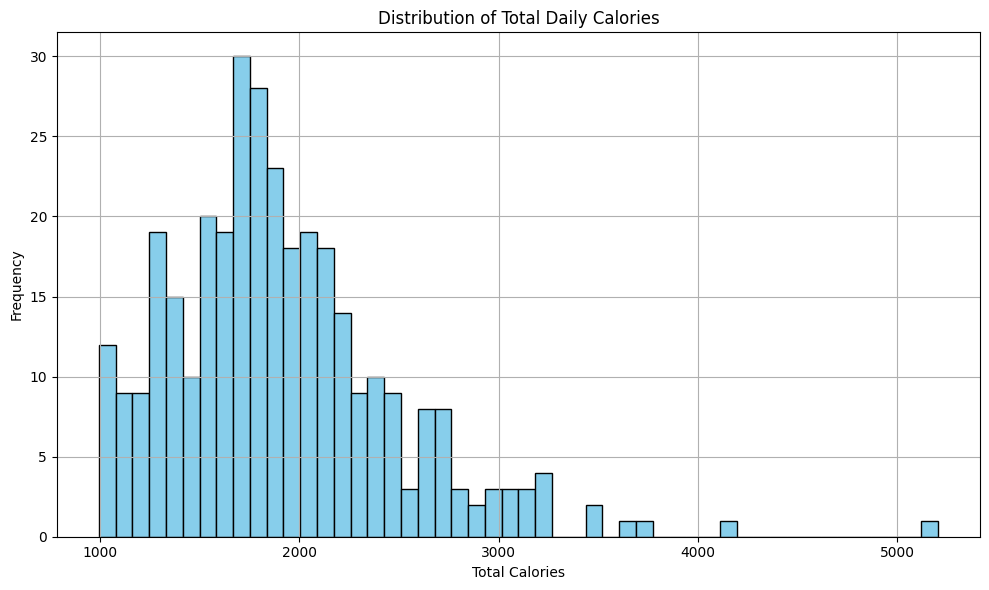

In [18]:
import matplotlib.pyplot as plt
import torch

def collect_total_calories(train_loader):
    """
    Collects total daily calories from the train_loader for histogram visualization.
    """
    all_calories = []

    for batch in train_loader:
        nutrition = batch["nutrition"]
        for day_meals in nutrition:
            if isinstance(day_meals, list):
                day_total = sum(meal.get("calories", 0) for meal in day_meals if isinstance(meal, dict))
                if day_total > 800:  # Apply the same filter used in compute_calorie_stats
                    all_calories.append(day_total)

    return all_calories

def plot_calorie_histogram(calories, bins=50):
    """
    Plots a histogram of total daily calories.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(calories, bins=bins, color='skyblue', edgecolor='black')
    plt.title("Distribution of Total Daily Calories")
    plt.xlabel("Total Calories")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
train_calories = collect_total_calories(train_loader)
plot_calorie_histogram(train_calories)


In [31]:
def train_unified_model(
    model, 
    train_loader, val_loader, 
    global_mean, global_std,
    epochs=30, 
    lr=1e-3, 
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Train a unified model with activity and CGM data.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The unified model to train
    train_loader : torch.utils.data.DataLoader
        DataLoader for training data
    val_loader : torch.utils.data.DataLoader
        DataLoader for validation data
    global_mean : float
        Mean value for label normalization
    global_std : float
        Standard deviation for label normalization
    epochs : int
        Number of training epochs
    lr : float
        Learning rate for optimizer
    device : str
        Device to train on ("cuda" or "cpu")
        
    Returns:
    --------
    training_losses : list
        List of training losses per epoch
    validation_losses : list
        List of validation losses per epoch
    """
    # Move model to device
    model.to(device)
    
    # Define loss function
    criterion = nn.MSELoss()  # or your custom RMSRELoss
    
    # Optimizer with weight decay for regularization
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    # Store loss values
    training_losses = []
    validation_losses = []
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    # Determine if we can use mixed precision
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    # Training loop
    from tqdm import tqdm
    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        # Set model to training mode
        model.train()
        
        epoch_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            # Extract data
            activity_data = batch["activity_data"].to(device)
            cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device)
            demographics = batch['demographics'].to(device)
            
            # Process labels
            if isinstance(batch["nutrition"], torch.Tensor):
                labels = (batch["nutrition"] - global_mean) / global_std
            else:
                # If nutrition is a list or dictionary, adjust accordingly
                labels = process_labels(batch["nutrition"], global_mean, global_std, device)
            labels = labels.float().to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass with optional mixed precision
            if use_amp:
                with torch.cuda.amp.autocast():
                    # Forward pass through unified model
                    pred = model(activity_data, cgm_data, demographics).squeeze(1)
                    
                    # Compute loss
                    loss = criterion(pred, labels)
                
                # Backpropagation with scaler
                scaler.scale(loss).backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                # Forward pass
                pred = model(activity_data, cgm_data, demographics).squeeze(1)
                
                # Compute loss
                loss = criterion(pred, labels)
                
                # Backpropagation
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
            
            # Print diagnostics for first batch of first epoch
            if epoch == 0 and batch_idx == 0:
                print(f"Sample predictions: {pred[:5]}")
                print(f"Sample labels: {labels[:5]}")
                print(f"Initial loss value: {loss.item()}")
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}")
        
        # Validation Loop
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                # Extract data
                activity_data = batch["activity_data"].to(device)
                cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device)
                demographics = batch['demographics'].to(device)
                
                # Process labels
                if isinstance(batch["nutrition"], torch.Tensor):
                    labels = (batch["nutrition"] - global_mean) / global_std
                else:
                    # If nutrition is a list or dictionary, adjust accordingly
                    labels = process_labels(batch["nutrition"], global_mean, global_std, device)
                labels = labels.float().to(device)
                
                # Forward pass
                pred = model(activity_data, cgm_data, demographics).squeeze(1)
                
                # Compute loss
                loss = criterion(pred, labels)
                val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }, 'best_model.pth')
            print(f"Saved new best model with validation loss: {avg_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        # Optional: print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")
    
    print("Training Complete!")
    return training_losses, validation_losses

In [29]:
import torch
import torch.nn as nn

class UnifiedLSTMModel(nn.Module):
    def __init__(self, 
                 activity_channels=2,
                 cgm_channels=1, 
                 seq_length=1440,
                 hidden_size=128,
                 num_layers=2,
                 dropout=0.2,
                 demographic_features=5,
                 output_size=1):
        super(UnifiedLSTMModel, self).__init__()
        
        # Total number of input channels/features
        self.total_channels = activity_channels + cgm_channels
        
        # Main LSTM for processing all time series data
        self.lstm = nn.LSTM(
            input_size=self.total_channels,  # All channels combined
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Attention mechanism (optional but helpful)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,  # * 2 for bidirectional
            num_heads=4,
            dropout=dropout
        )
        
        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(hidden_size * 2 + demographic_features, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        # Batch normalization for improved training stability
        self.bn1 = nn.BatchNorm1d(hidden_size * 2)
        self.bn2 = nn.BatchNorm1d(hidden_size)
    
    def forward(self, activity_data, cgm_data, demographics):
        batch_size = activity_data.size(0)
        
        # Prepare and combine all time series data
        # Reshape inputs to ensure consistent dimensions
        if len(cgm_data.shape) == 3:  # If already [batch, channels, seq]
            cgm_data = cgm_data.permute(0, 2, 1)  # -> [batch, seq, channels]
        elif len(cgm_data.shape) == 2:  # If [batch, seq]
            cgm_data = cgm_data.unsqueeze(-1)  # -> [batch, seq, 1]
            
        activity_data = activity_data.permute(0, 2, 1)  # [batch, seq, channels]
            
        # Concatenate all time series features along the channel dimension
        combined_data = torch.cat([activity_data, cgm_data], dim=2)
        
        # Process through LSTM
        lstm_out, (hidden, _) = self.lstm(combined_data)
        
        # Apply attention mechanism
        lstm_out = lstm_out.permute(1, 0, 2)  # [seq, batch, features]
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_out = attn_out.permute(1, 0, 2)  # [batch, seq, features]
        
        # Get context vector (last hidden state)
        context = attn_out[:, -1, :]  # Use the last time step
        context = self.bn1(context)  # Apply batch normalization
        
        # Concatenate with demographics
        combined_features = torch.cat([context, demographics], dim=1)
        
        # Final prediction layers
        x = self.fc1(combined_features)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.fc2(x)
        
        return output

In [35]:
# Initialize the unified model (without meal time features)
unified_model = UnifiedLSTMModel(
    activity_channels=2,
    cgm_channels=1,
    seq_length=1440,
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    demographic_features=5,
    output_size=1
)

# Train the model
training_losses, validation_losses = train_unified_model(
    unified_model,
    train_loader,
    test_loader,
    global_mean=2000,
    global_std=300,
    epochs=30,
    lr=1e-3
)

/tmp/ipykernel_1637384/559066402.py:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_1637384/559066402.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Sample predictions: tensor([ 0.5942, -0.4089, -0.2798,  0.1531, -0.4253], device='cuda:0',
       dtype=torch.float16, grad_fn=<SliceBackward0>)
Sample labels: tensor([-1.8267,  0.9100, -2.4767, -2.4433, -1.4633], device='cuda:0')
Initial loss value: 3.225468635559082
Epoch [1/30], Training Loss: 3.6601


Training Epochs:   3%|▎         | 1/30 [00:03<01:50,  3.82s/it]

Epoch [1/30], Validation Loss: 3.9155
Saved new best model with validation loss: 3.9155
Current learning rate: 0.001
Epoch [2/30], Training Loss: 3.3300


Training Epochs:   7%|▋         | 2/30 [00:07<01:46,  3.79s/it]

Epoch [2/30], Validation Loss: 3.7399
Saved new best model with validation loss: 3.7399
Current learning rate: 0.001
Epoch [3/30], Training Loss: 3.3834


Training Epochs:  10%|█         | 3/30 [00:11<01:42,  3.78s/it]

Epoch [3/30], Validation Loss: 3.7136
Saved new best model with validation loss: 3.7136
Current learning rate: 0.001
Epoch [4/30], Training Loss: 3.4337


Training Epochs:  13%|█▎        | 4/30 [00:15<01:37,  3.76s/it]

Epoch [4/30], Validation Loss: 3.7553
Current learning rate: 0.001
Epoch [5/30], Training Loss: 3.2725


Training Epochs:  17%|█▋        | 5/30 [00:18<01:33,  3.75s/it]

Epoch [5/30], Validation Loss: 3.7185
Current learning rate: 0.001
Epoch [6/30], Training Loss: 3.3886


Training Epochs:  20%|██        | 6/30 [00:22<01:29,  3.75s/it]

Epoch [6/30], Validation Loss: 4.6449
Current learning rate: 0.001
Epoch [7/30], Training Loss: 3.3597


Training Epochs:  23%|██▎       | 7/30 [00:26<01:26,  3.75s/it]

Epoch [7/30], Validation Loss: 3.6103
Saved new best model with validation loss: 3.6103
Current learning rate: 0.001
Epoch [8/30], Training Loss: 3.1899


Training Epochs:  27%|██▋       | 8/30 [00:30<01:22,  3.76s/it]

Epoch [8/30], Validation Loss: 3.5842
Saved new best model with validation loss: 3.5842
Current learning rate: 0.001
Epoch [9/30], Training Loss: 3.2932


Training Epochs:  30%|███       | 9/30 [00:33<01:18,  3.76s/it]

Epoch [9/30], Validation Loss: 3.6605
Current learning rate: 0.001
Epoch [10/30], Training Loss: 3.2629


Training Epochs:  33%|███▎      | 10/30 [00:37<01:15,  3.76s/it]

Epoch [10/30], Validation Loss: 3.9158
Current learning rate: 0.001
Epoch [11/30], Training Loss: 3.1931


Training Epochs:  37%|███▋      | 11/30 [00:41<01:11,  3.76s/it]

Epoch [11/30], Validation Loss: 3.6249
Current learning rate: 0.001
Epoch [12/30], Training Loss: 3.2860


Training Epochs:  40%|████      | 12/30 [00:45<01:07,  3.75s/it]

Epoch [12/30], Validation Loss: 3.7385
Current learning rate: 0.0005
Epoch [13/30], Training Loss: 3.2548


Training Epochs:  43%|████▎     | 13/30 [00:48<01:03,  3.75s/it]

Epoch [13/30], Validation Loss: 4.1433
Current learning rate: 0.0005
Epoch [14/30], Training Loss: 3.3010


Training Epochs:  47%|████▋     | 14/30 [00:52<00:59,  3.74s/it]

Epoch [14/30], Validation Loss: 3.6314
Current learning rate: 0.0005
Epoch [15/30], Training Loss: 3.1972


Training Epochs:  50%|█████     | 15/30 [00:56<00:56,  3.74s/it]

Epoch [15/30], Validation Loss: 3.4937
Saved new best model with validation loss: 3.4937
Current learning rate: 0.0005
Epoch [16/30], Training Loss: 2.9662


Training Epochs:  53%|█████▎    | 16/30 [01:00<00:52,  3.75s/it]

Epoch [16/30], Validation Loss: 3.3825
Saved new best model with validation loss: 3.3825
Current learning rate: 0.0005
Epoch [17/30], Training Loss: 3.0412


Training Epochs:  57%|█████▋    | 17/30 [01:03<00:48,  3.74s/it]

Epoch [17/30], Validation Loss: 3.5062
Current learning rate: 0.0005
Epoch [18/30], Training Loss: 3.0758


Training Epochs:  60%|██████    | 18/30 [01:07<00:44,  3.74s/it]

Epoch [18/30], Validation Loss: 3.5137
Current learning rate: 0.0005
Epoch [19/30], Training Loss: 2.9310


Training Epochs:  63%|██████▎   | 19/30 [01:11<00:41,  3.74s/it]

Epoch [19/30], Validation Loss: 3.4194
Current learning rate: 0.0005
Epoch [20/30], Training Loss: 2.8319


Training Epochs:  67%|██████▋   | 20/30 [01:15<00:37,  3.74s/it]

Epoch [20/30], Validation Loss: 3.9283
Current learning rate: 0.00025
Epoch [21/30], Training Loss: 2.7665


Training Epochs:  70%|███████   | 21/30 [01:18<00:33,  3.74s/it]

Epoch [21/30], Validation Loss: 3.3480
Saved new best model with validation loss: 3.3480
Current learning rate: 0.00025
Epoch [22/30], Training Loss: 2.8383


Training Epochs:  73%|███████▎  | 22/30 [01:22<00:30,  3.75s/it]

Epoch [22/30], Validation Loss: 3.4448
Current learning rate: 0.00025
Epoch [23/30], Training Loss: 2.8035


Training Epochs:  77%|███████▋  | 23/30 [01:26<00:26,  3.75s/it]

Epoch [23/30], Validation Loss: 3.4165
Current learning rate: 0.00025
Epoch [24/30], Training Loss: 2.7234


Training Epochs:  80%|████████  | 24/30 [01:29<00:22,  3.74s/it]

Epoch [24/30], Validation Loss: 3.6152
Current learning rate: 0.00025
Epoch [25/30], Training Loss: 2.7277


Training Epochs:  83%|████████▎ | 25/30 [01:33<00:18,  3.74s/it]

Epoch [25/30], Validation Loss: 3.4644
Current learning rate: 0.000125
Epoch [26/30], Training Loss: 2.8118


Training Epochs:  87%|████████▋ | 26/30 [01:37<00:14,  3.74s/it]

Epoch [26/30], Validation Loss: 3.3572
Current learning rate: 0.000125
Epoch [27/30], Training Loss: 2.8048


Training Epochs:  90%|█████████ | 27/30 [01:41<00:11,  3.74s/it]

Epoch [27/30], Validation Loss: 3.3683
Current learning rate: 0.000125
Epoch [28/30], Training Loss: 2.7654


Training Epochs:  90%|█████████ | 27/30 [01:44<00:11,  3.89s/it]

Epoch [28/30], Validation Loss: 3.4262
Early stopping triggered after 28 epochs
Training Complete!
